In [2]:
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import os
print(os.getcwd())  # 获取当前工作目录
# 设置新的工作目录
os.chdir('/root/Project/VAE_models/CVAE_MoG')
print(os.getcwd())  # 确认工作目录已改变
from models import VAE, CVAE_MoG
from utils import set_seed, generate_data
from training import train
from visualization import visualize_latent
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # 高清显示
plt.rcParams['figure.figsize'] = [3.3, 3]  # 设置默认大小

/root/Project/VAE_models/CVAE_MoG
/root/Project/VAE_models/CVAE_MoG


/usr/local/miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 模拟数据测试

In [16]:
set_seed(23)
# 参数
NUM_SAMPLES, FEATURE_DIM, NUM_CLASSES, COND_DIM, CONT_DIM = 1000, 200, 3, 3, 0
LATENT_DIM, HIDDEN_DIM, EPOCHS = 100, 128, 150

# 数据
data, real_labels, cont_attrs, cond_labels = generate_data(
    n_samples=NUM_SAMPLES, num_classes=NUM_CLASSES,
    feature_dim=FEATURE_DIM, cond_dim=COND_DIM, cont_dim=CONT_DIM
)
dataset = TensorDataset(data, cond_labels, cont_attrs)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### VAE训练及潜变量UMAP

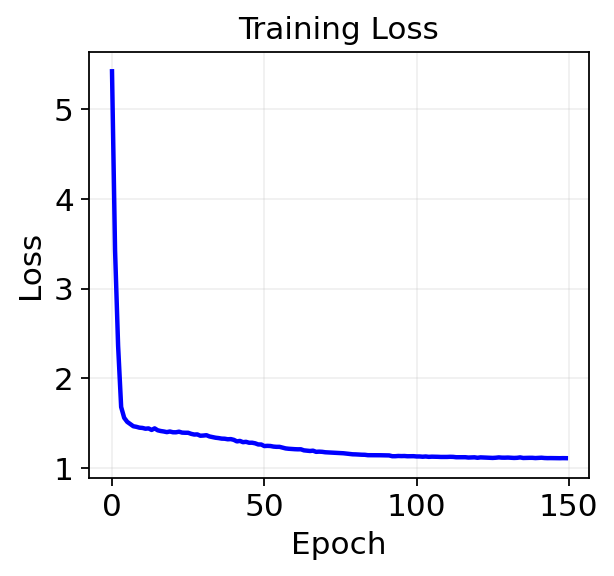

/root/Project/VAE_models/CVAE_MoG/visualization.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


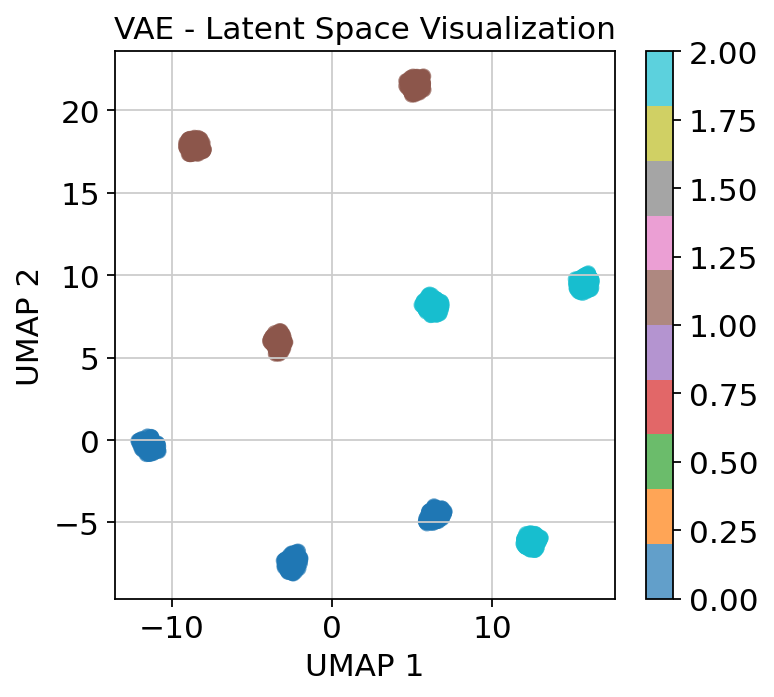

In [17]:
# -------- 训练 VAE（无条件） --------
vae = VAE(FEATURE_DIM, LATENT_DIM, HIDDEN_DIM)
opt_vae = optim.Adam(vae.parameters(), lr=1e-3)
train(vae, dataloader, opt_vae, EPOCHS, conditional=False)
visualize_latent(vae, data, real_labels, cont_attrs, cond_labels, conditional=False, title="VAE") #, save_path="vae_visualization.png")

### CVAE_MoG训练和潜变量的UMAP

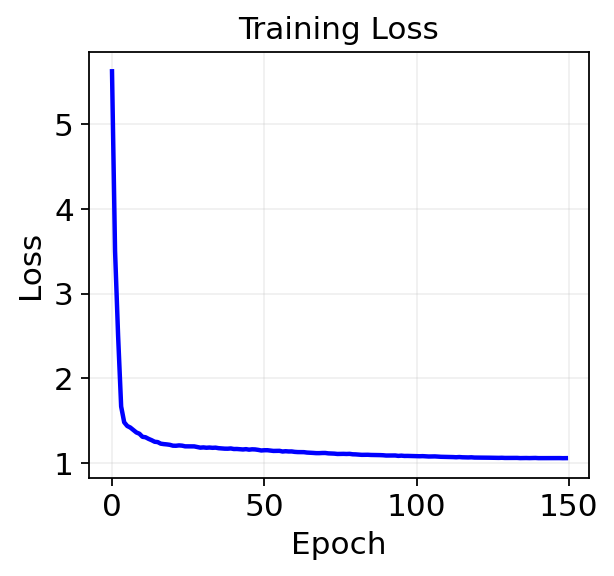

/root/Project/VAE_models/CVAE_MoG/visualization.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)
/root/Project/VAE_models/CVAE_MoG/visualization.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_disc = torch.tensor(cond_labels, dtype=torch.long) if conditional else None
/root/Project/VAE_models/CVAE_MoG/visualization.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_cont = torch.tensor(cont_attrs, dtype=torch.float32) if conditional else None


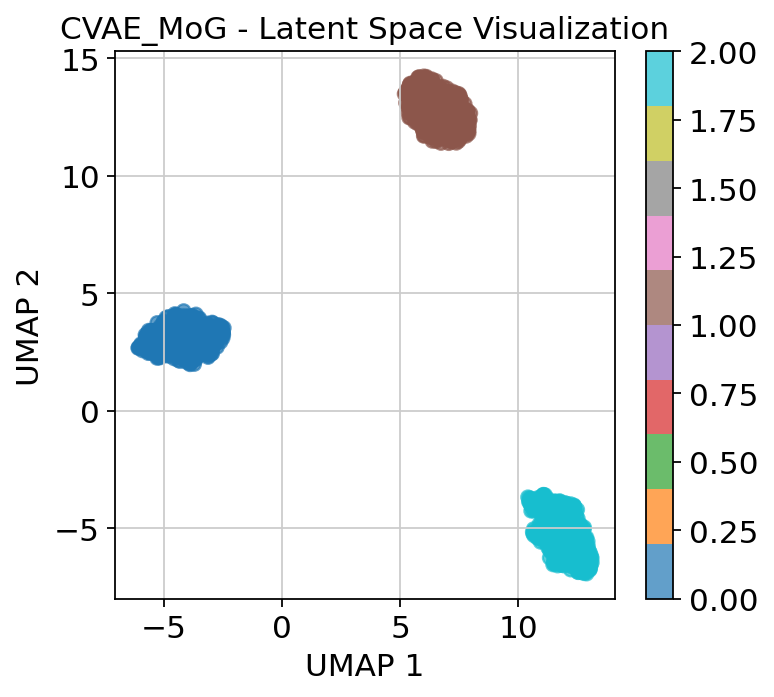

In [18]:
# -------- 训练 CVAE_MoG (带条件) --------
cvae = CVAE_MoG(FEATURE_DIM, COND_DIM, CONT_DIM, LATENT_DIM, HIDDEN_DIM)
opt_cvae = optim.Adam(cvae.parameters(), lr=1e-3)
train(cvae, dataloader, opt_cvae, EPOCHS, conditional=True)
visualize_latent(cvae, data, real_labels, cont_attrs, cond_labels, conditional=True, title="CVAE_MoG") #, save_path="cvae_mog_visualization.png")

## 真实单细胞数据测试

In [3]:
# 设置新的工作目录
import os
os.chdir('/root/Project/VAE_models/CVAE_MoG')
print(os.getcwd())  # 确认工作目录已改变
from data_processing import preprocess_data
import pandas as pd
import numpy as np
import scanpy as sc
import gzip
from pathlib import Path

# 设置scanpy参数
sc.settings.verbosity = 3  # 详细输出
sc.settings.set_figure_params(dpi=80, facecolor='white')

/root/Project/VAE_models/CVAE_MoG


In [3]:
adata = sc.read_h5ad('/root/Project/VAE_models/CVAE_MoG/data/GSE149614_HCC_scRNA_nonfiltered.h5ad')
print(adata)
adata.obs.head()

AnnData object with n_obs × n_vars = 71914 × 25712
    obs: 'sample', 'res.3', 'site', 'patient', 'stage', 'virus', 'celltype'


,sample,res.3,site,patient,stage,virus,celltype
Cell,,,,,,,
HCC01T_AAACCTGAGTCGCCGT,HCC01T,16,Tumor,HCC01,I,HBV,Myeloid
HCC01T_AAACCTGCATTACCTT,HCC01T,25,Tumor,HCC01,I,HBV,T/NK
HCC01T_AAACCTGGTCACACGC,HCC01T,2,Tumor,HCC01,I,HBV,T/NK
HCC01T_AAACCTGTCCAGTATG,HCC01T,2,Tumor,HCC01,I,HBV,T/NK
HCC01T_AAACGGGTCGAGCCCA,HCC01T,38,Tumor,HCC01,I,HBV,Myeloid


In [4]:
# 预处理数据
adata = preprocess_data(adata)
# 保存处理后的数据
adata.write('/root/Project/VAE_models/CVAE_MoG/data/GSE149614_HCC_scRNA.h5ad')
print(f"处理后的数据包含 {adata.n_obs} 个细胞和 {adata.n_vars} 个基因")
# metadata前几行
adata.obs.head()

原始数据形状: (71914, 25712)
过滤低质量细胞和基因...
filtered out 233 genes that are detected in less than 3 cells
过滤后数据形状: (71914, 25479)
进行数据标准化...
normalizing counts per cell
    finished (0:00:00)
寻找高变基因...
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
进行z-score标准化...


/usr/local/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/miniconda3/envs/py310/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


最终处理后数据形状: (71914, 2000)
处理后的数据包含 71914 个细胞和 2000 个基因


,sample,res.3,site,patient,stage,virus,celltype,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes
Cell,,,,,,,,,,,,
HCC01T_AAACCTGAGTCGCCGT,HCC01T,16,Tumor,HCC01,I,HBV,Myeloid,2826,13864.0,748.0,5.395268,2826
HCC01T_AAACCTGCATTACCTT,HCC01T,25,Tumor,HCC01,I,HBV,T/NK,1282,3660.0,648.0,17.704918,1282
HCC01T_AAACCTGGTCACACGC,HCC01T,2,Tumor,HCC01,I,HBV,T/NK,1227,3840.0,132.0,3.437500,1227
HCC01T_AAACCTGTCCAGTATG,HCC01T,2,Tumor,HCC01,I,HBV,T/NK,1336,4102.0,151.0,3.681131,1336
HCC01T_AAACGGGTCGAGCCCA,HCC01T,38,Tumor,HCC01,I,HBV,Myeloid,1553,6421.0,1184.0,18.439495,1553


In [11]:
print(adata.obs["sample"].value_counts().to_dict())

{'HCC08T': 4833, 'HCC03T': 4825, 'HCC08N': 4795, 'HCC05N': 4656, 'HCC06N': 4465, 'HCC06T': 4308, 'HCC08P': 4142, 'HCC02T': 4101, 'HCC07N': 3740, 'HCC04T': 3501, 'HCC04N': 3396, 'HCC01T': 3367, 'HCC05T': 3353, 'HCC10N': 3072, 'HCC10L': 2843, 'HCC09T': 2816, 'HCC10T': 2799, 'HCC03N': 2601, 'HCC09N': 1962, 'HCC07P': 1829, 'HCC07T': 510}


In [1]:
from data_processing import load_singlecell_data, add_latent_to_adata
import scanpy as sc

# 读取处理后的数据
adata = sc.read_h5ad('/root/Project/VAE_models/CVAE_MoG/data/GSE149614_HCC_scRNA.h5ad')
print(adata)

X, y_discrete, y_cont = load_singlecell_data(
    adata, 
    discrete_key="sample",  # 根据实际元数据列名调整
    cont_keys=["total_counts", "pct_counts_mt"]  # 根据实际元数据列名调整
)
print(f"基因表达数据形状: {X.shape}")
print(f"离散条件形状: {y_discrete.shape}")
print(f"连续条件形状: {y_cont.shape}")

AnnData object with n_obs × n_vars = 71914 × 2000
    obs: 'sample', 'res.3', 'site', 'patient', 'stage', 'virus', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
基因表达数据形状: torch.Size([71914, 2000])
离散条件形状: torch.Size([71914])
连续条件形状: torch.Size([71914, 2])


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:39)


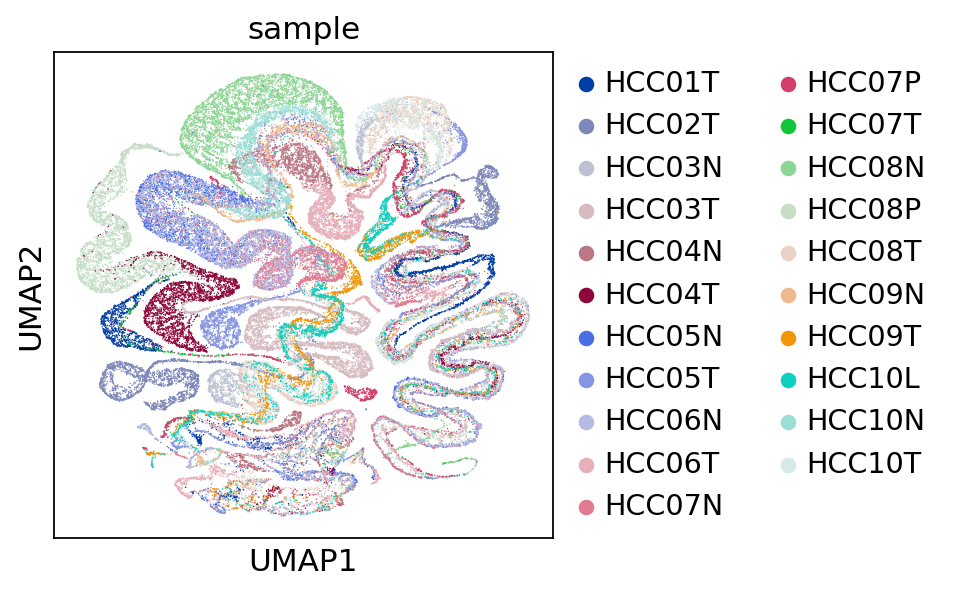

In [ ]:
from data_processing import load_singlecell_data, add_latent_to_adata
adata = add_latent_to_adata(cvae,adata,"sample",cont_keys=None)
# 使用scanpy可视化
sc.pp.neighbors(adata, use_rep="X_latent")
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")

In [9]:
# 设置新的工作目录
import os
os.chdir('/root/Project/VAE_models/CVAE_MoG')
print(os.getcwd())  # 确认工作目录已改变
from data_processing import preprocess_data
import pandas as pd
import numpy as np
import scanpy as sc
import gzip
from pathlib import Path

# 设置scanpy参数
sc.settings.verbosity = 3  # 详细输出
sc.settings.set_figure_params(dpi=80, facecolor='white')

/root/Project/VAE_models/CVAE_MoG


In [10]:
# 读取处理后的数据
adata = sc.read_h5ad('/root/Project/VAE_models/CVAE_MoG/data/GSE149614_HCC_scRNA_with_embeddings.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 71914 × 1987
    obs: 'sample', 'res.3', 'site', 'patient', 'stage', 'virus', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'sample_colors', 'umap'
    obsm: 'CVAE_MoG_NB_umap', 'CVAE_MoG_umap', 'VAE_NB_umap', 'VAE_umap', 'X_latent_cvae_gaussian', 'X_latent_vae', 'X_umap', 'harmony_umap', 'scanpy_umap'
    obsp: 'connectivities', 'distances'


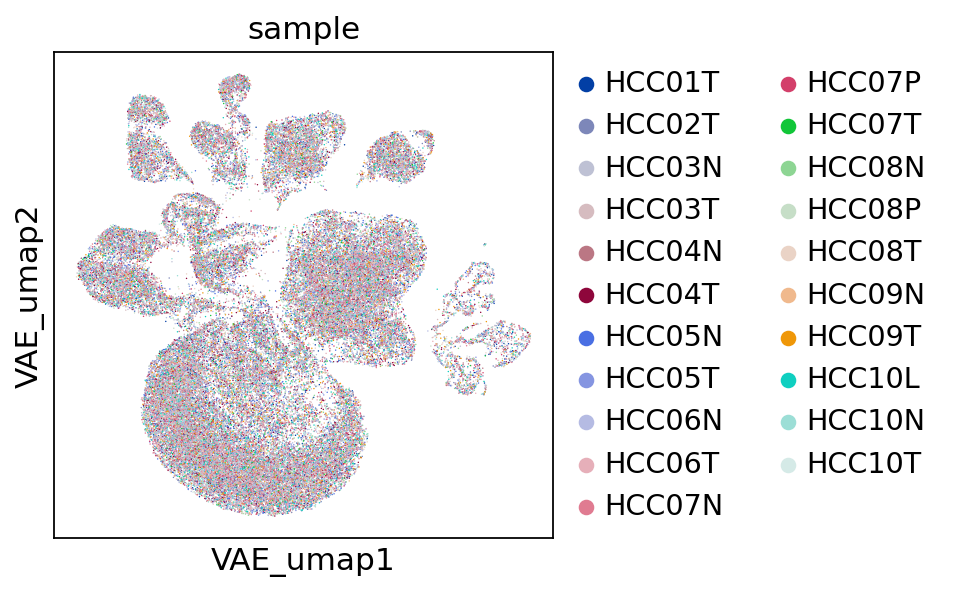

In [11]:
sc.pl.embedding(adata, basis='VAE_umap', color='sample')

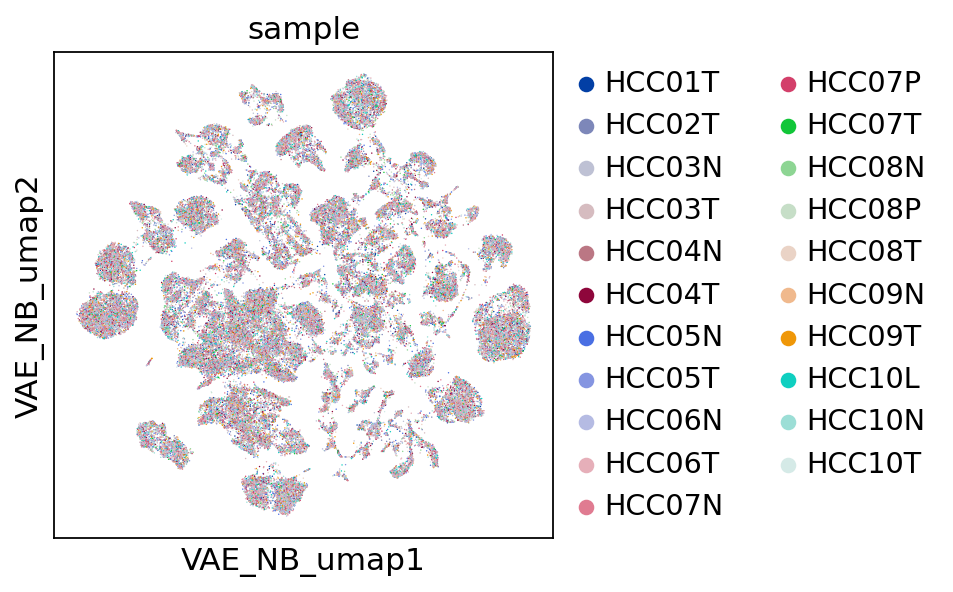

In [12]:
sc.pl.embedding(adata, basis='VAE_NB_umap', color='sample')

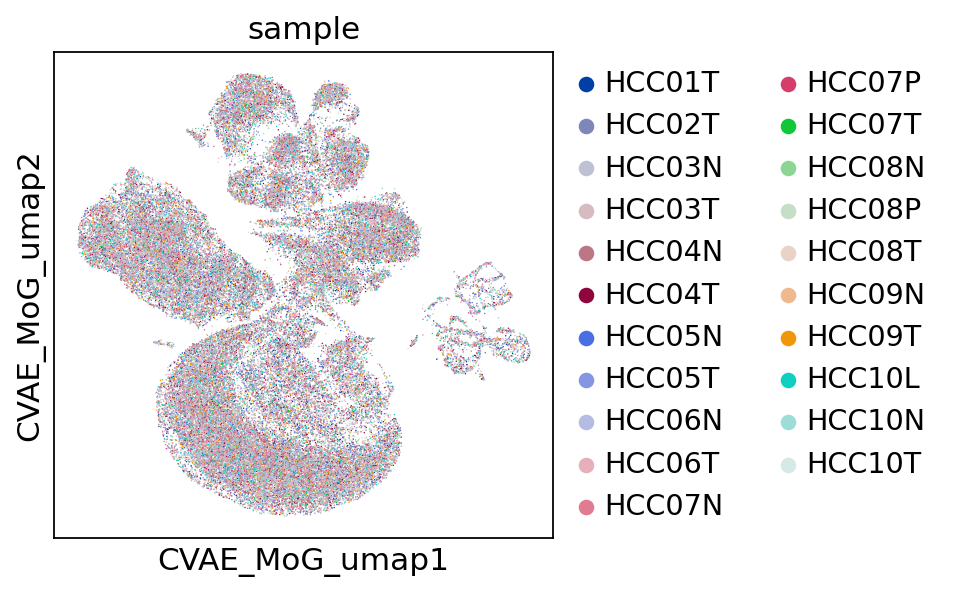

In [13]:
sc.pl.embedding(adata, basis='CVAE_MoG_umap', color='sample')

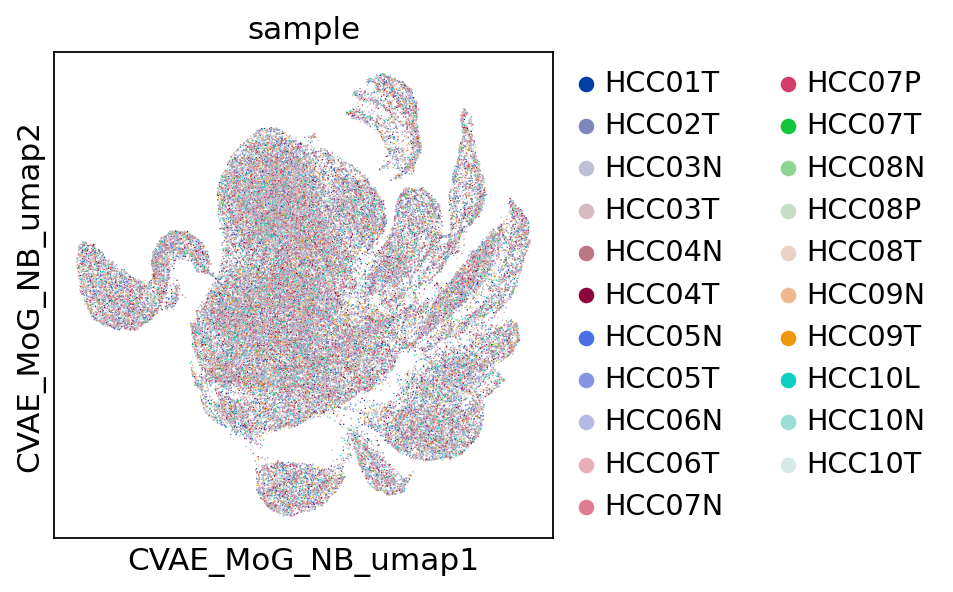

In [14]:
sc.pl.embedding(adata, basis='CVAE_MoG_NB_umap', color='sample')

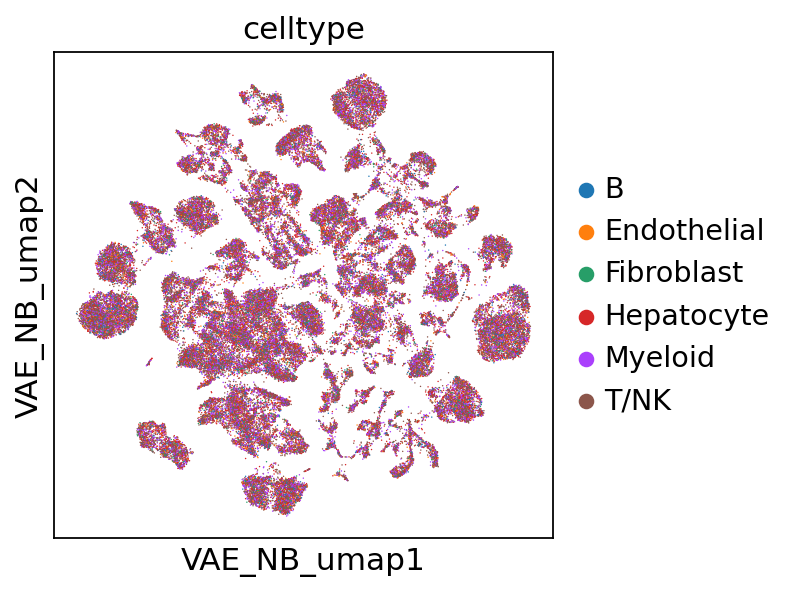

In [15]:
sc.pl.embedding(adata, basis='VAE_NB_umap', color='celltype')

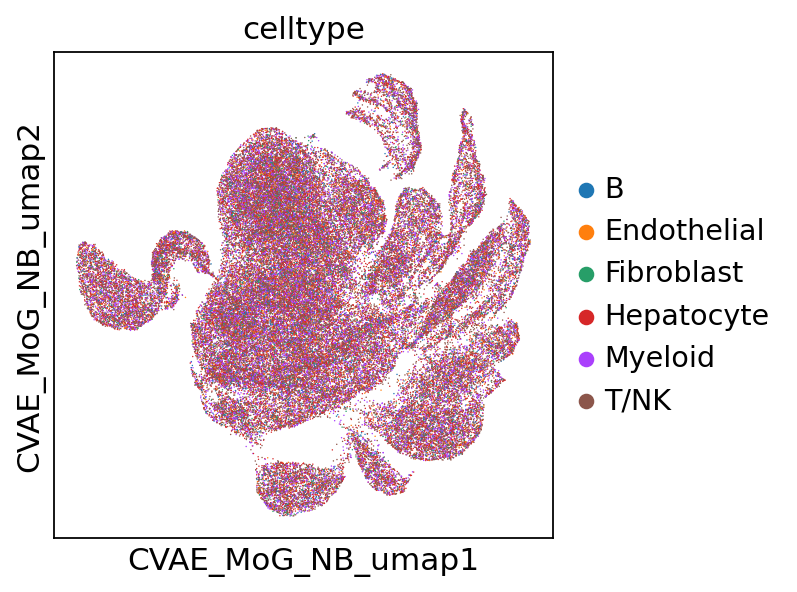

In [16]:
sc.pl.embedding(adata, basis='CVAE_MoG_NB_umap', color='celltype')